# Insurance Model

## 1. Loading the data and relevant libraries

In [143]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from pandas.plotting import scatter_matrix

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("https://open-data.s3.filebase.com/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 2. Preprocessing the data 

In [3]:
# Converting sex to a binary variable
df['Female'] = 0
df.loc[df['sex'] == 'female','Female'] = 1
df.head()

,age,sex,bmi,children,smoker,region,charges,Female
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0


In [4]:
# Converting smoker to a binary variable
df.loc[df['smoker'] == 'yes','smoker'] = 1
df.loc[df['smoker'] == 'no','smoker'] = 0
df.head()

,age,sex,bmi,children,smoker,region,charges,Female
0,19,female,27.900,0,1,southwest,16884.92400,1
1,18,male,33.770,1,0,southeast,1725.55230,0
2,28,male,33.000,3,0,southeast,4449.46200,0
3,33,male,22.705,0,0,northwest,21984.47061,0
4,32,male,28.880,0,0,northwest,3866.85520,0


In [5]:
# Creating dummy variables for regions
print(df['region'].value_counts())
df['southeast'] = 0
df['southwest'] = 0
df['northwest'] = 0
df.loc[df['region'] == 'southeast','southeast'] = 1
df.loc[df['region'] == 'southwest','southwest'] = 1
df.loc[df['region'] == 'northwest','northwest'] = 1
df.head()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


,age,sex,bmi,children,smoker,region,charges,Female,southeast,southwest,northwest
0,19,female,27.900,0,1,southwest,16884.92400,1,0,1,0
1,18,male,33.770,1,0,southeast,1725.55230,0,1,0,0
2,28,male,33.000,3,0,southeast,4449.46200,0,1,0,0
3,33,male,22.705,0,0,northwest,21984.47061,0,0,0,1
4,32,male,28.880,0,0,northwest,3866.85520,0,0,0,1


In [7]:
df2 = df.drop(['sex','region'], axis = 1)
df2.head()

,age,bmi,children,smoker,charges,Female,southeast,southwest,northwest
0,19,27.900,0,1,16884.92400,1,0,1,0
1,18,33.770,1,0,1725.55230,0,1,0,0
2,28,33.000,3,0,4449.46200,0,1,0,0
3,33,22.705,0,0,21984.47061,0,0,0,1
4,32,28.880,0,0,3866.85520,0,0,0,1


### Creating log of charges since Charges looks exponentially distributed

In [8]:
df2['log_charges'] = np.log(df2['charges'])
df2.head()

,age,bmi,children,smoker,charges,Female,southeast,southwest,northwest,log_charges
0,19,27.900,0,1,16884.92400,1,0,1,0,9.734176
1,18,33.770,1,0,1725.55230,0,1,0,0,7.453302
2,28,33.000,3,0,4449.46200,0,1,0,0,8.400538
3,33,22.705,0,0,21984.47061,0,0,0,1,9.998092
4,32,28.880,0,0,3866.85520,0,0,0,1,8.260197


In [9]:
scaled_df2 = df2
scaler = StandardScaler()
scaled_df2[['age','bmi','children']] = scaler.fit_transform(df2[['age','bmi','children']])
#scaled_df2 = pd.DataFrame(scaled_df2, columns=['age','bmi','children','smoker','charges','Female','southeast','southwest','northwest','log_charges'])
scaled_df2.head()

,age,bmi,children,smoker,charges,Female,southeast,southwest,northwest,log_charges
0,-1.438764,-0.453320,-0.908614,1,16884.92400,1,0,1,0,9.734176
1,-1.509965,0.509621,-0.078767,0,1725.55230,0,1,0,0,7.453302
2,-0.797954,0.383307,1.580926,0,4449.46200,0,1,0,0,8.400538
3,-0.441948,-1.305531,-0.908614,0,21984.47061,0,0,0,1,9.998092
4,-0.513149,-0.292556,-0.908614,0,3866.85520,0,0,0,1,8.260197


In [13]:
df2 = df2.drop(['charges'],axis = 1)

In [14]:
df2.head()

,age,bmi,children,smoker,Female,southeast,southwest,northwest,log_charges
0,-1.438764,-0.453320,-0.908614,1,1,0,1,0,9.734176
1,-1.509965,0.509621,-0.078767,0,0,1,0,0,7.453302
2,-0.797954,0.383307,1.580926,0,0,1,0,0,8.400538
3,-0.441948,-1.305531,-0.908614,0,0,0,0,1,9.998092
4,-0.513149,-0.292556,-0.908614,0,0,0,0,1,8.260197


In [58]:
scaled_df2 = scaled_df2.drop(['charges'],axis = 1)

In [59]:
scaled_df2.head()

,age,bmi,children,smoker,Female,southeast,southwest,northwest,log_charges
0,-1.438764,-0.453320,-0.908614,1,1,0,1,0,9.734176
1,-1.509965,0.509621,-0.078767,0,0,1,0,0,7.453302
2,-0.797954,0.383307,1.580926,0,0,1,0,0,8.400538
3,-0.441948,-1.305531,-0.908614,0,0,0,0,1,9.998092
4,-0.513149,-0.292556,-0.908614,0,0,0,0,1,8.260197


## 3. Exploratory Data Analysis

In [15]:
df.shape

(1338, 11)

In [16]:
df.describe()

,age,bmi,children,charges,Female,southeast,southwest,northwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,0.494768,0.272048,0.242900,0.242900
std,14.049960,6.098187,1.205493,12110.011237,0.500160,0.445181,0.428995,0.428995
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000
25%,27.000000,26.296250,0.000000,4740.287150,0.000000,0.000000,0.000000,0.000000
50%,39.000000,30.400000,1.000000,9382.033000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,34.693750,2.000000,16639.912515,1.000000,1.000000,0.000000,0.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000,1.000000,1.000000,1.000000


In [17]:
#Checking for any null values
df.isnull().values.any()

False

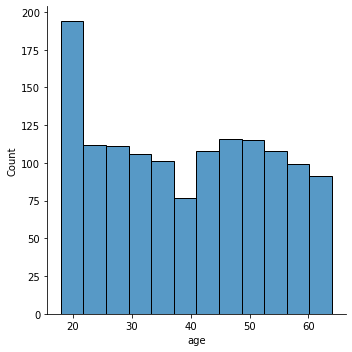

In [18]:
sns.displot(df['age'], kind = 'hist')

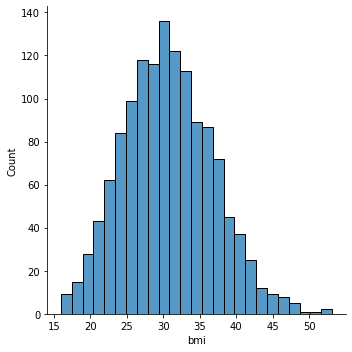

In [19]:
sns.displot(df['bmi'], kind = 'hist')

## The distribution of charges is exponentially distributed

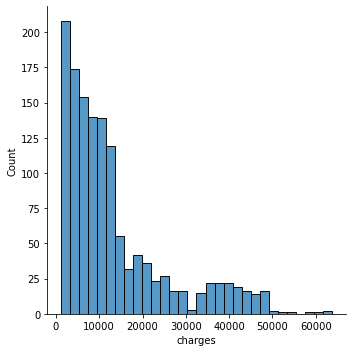

In [20]:
sns.displot(df['charges'], kind = 'hist')

## The log of charges is closer to normal distribution

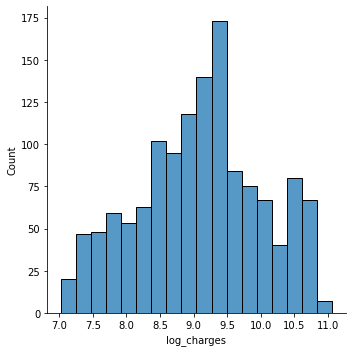

In [22]:
sns.displot(df2['log_charges'], kind = 'hist')

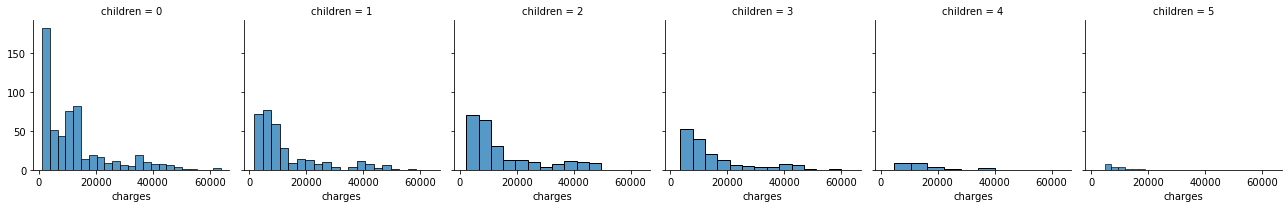

In [23]:
g = sns.FacetGrid(df, col="children")
g.map(sns.histplot, "charges")

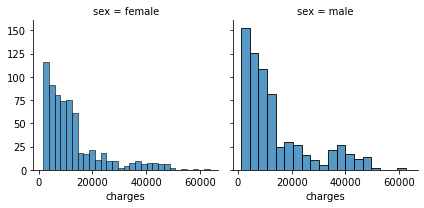

In [24]:
g = sns.FacetGrid(df, col="sex")
g.map(sns.histplot, "charges")

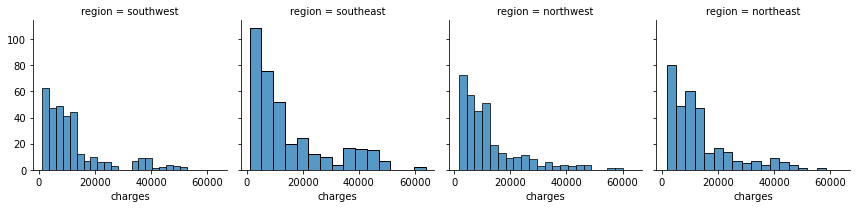

In [25]:
g = sns.FacetGrid(df, col="region")
g.map(sns.histplot, "charges")

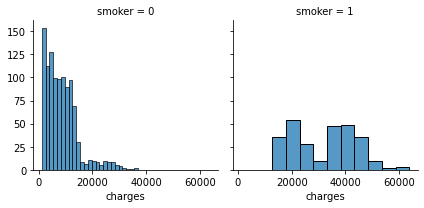

In [26]:
g = sns.FacetGrid(df, col="smoker")
g.map(sns.histplot, "charges")

<AxesSubplot:xlabel='bmi', ylabel='charges'>

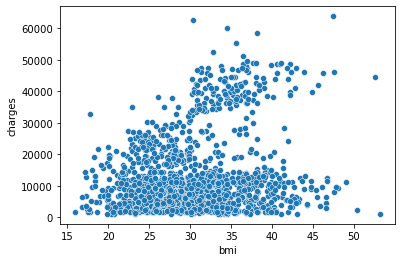

In [27]:
sns.scatterplot(data = df, x = "bmi", y = "charges")

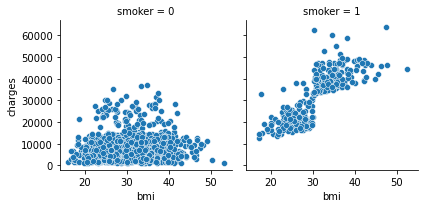

In [28]:
g = sns.FacetGrid(df, col="smoker")
g.map(sns.scatterplot, "bmi","charges")

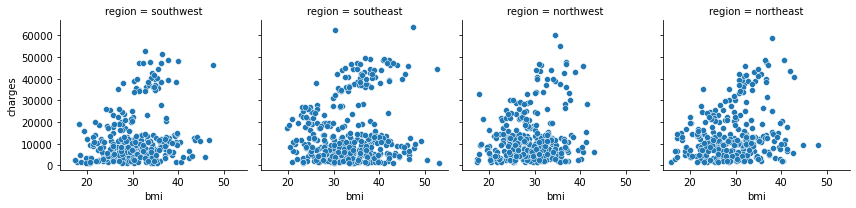

In [29]:
g = sns.FacetGrid(df, col="region")
g.map(sns.scatterplot, "bmi","charges")

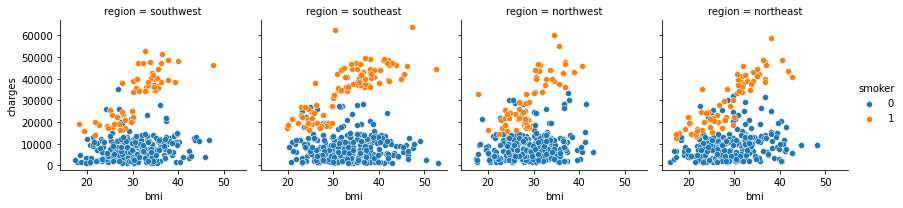

In [30]:
g = sns.FacetGrid(df, col="region", hue = "smoker")
g.map(sns.scatterplot, "bmi","charges")
g.add_legend()

<AxesSubplot:xlabel='age', ylabel='charges'>

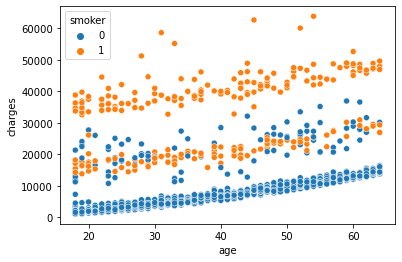

In [31]:
sns.scatterplot(data = df, x = "age", y = "charges", hue = "smoker")

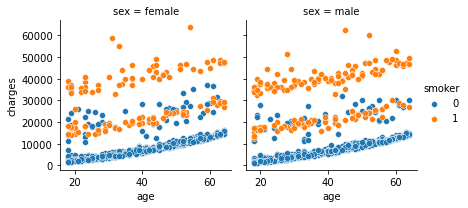

In [32]:
g = sns.FacetGrid(df, col="sex", hue= "smoker")
g.map(sns.scatterplot, "age","charges")
g.add_legend()

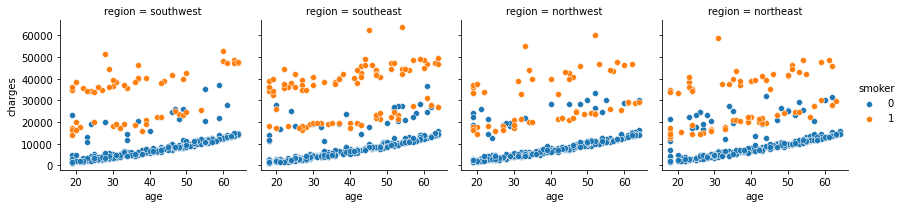

In [33]:
g = sns.FacetGrid(df, col="region", hue = "smoker")
g.map(sns.scatterplot, "age","charges")
g.add_legend()

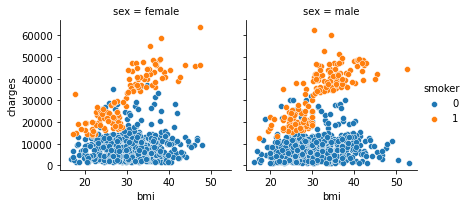

In [34]:
g = sns.FacetGrid(df, col="sex", hue="smoker")
g.map(sns.scatterplot, "bmi", "charges")
g.add_legend()

<AxesSubplot:xlabel='region', ylabel='charges'>

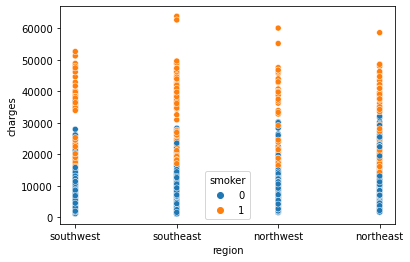

In [35]:
sns.scatterplot(data = df, x = "region",y = "charges", hue = "smoker")

<AxesSubplot:xlabel='sex', ylabel='charges'>

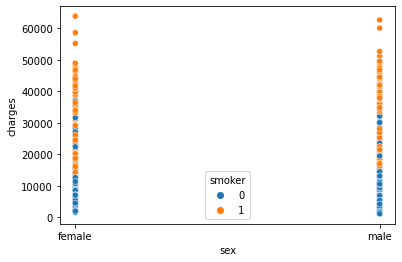

In [36]:
sns.scatterplot(data = df, x = "sex",y = "charges", hue = "smoker")

<AxesSubplot:xlabel='smoker', ylabel='charges'>

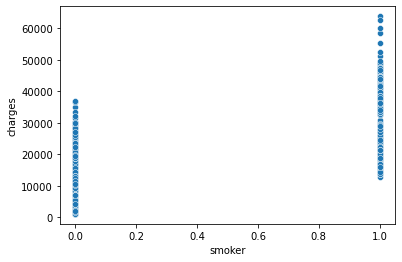

In [37]:
sns.scatterplot(data = df, x = "smoker",y = "charges")

<AxesSubplot:xlabel='children', ylabel='charges'>

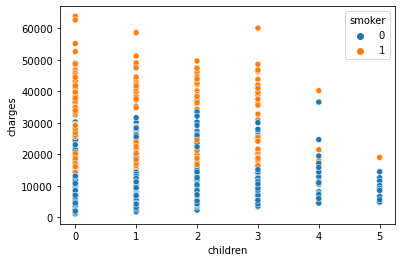

In [38]:
sns.scatterplot(data = df, x = "children",y = "charges", hue = "smoker")

### Visualising above data again but this time with Log of Charges 

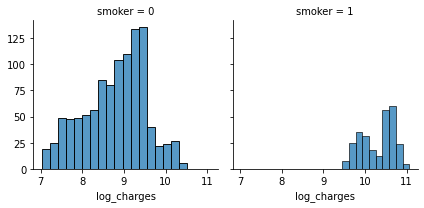

In [39]:
g = sns.FacetGrid(df2, col="smoker")
g.map(sns.histplot, "log_charges")

<AxesSubplot:xlabel='bmi', ylabel='log_charges'>

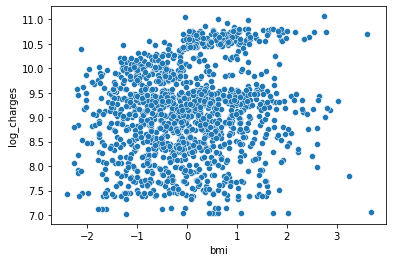

In [40]:
sns.scatterplot(data = df2, x = "bmi", y = "log_charges")

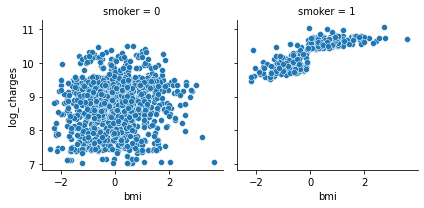

In [41]:
g = sns.FacetGrid(df2, col="smoker")
g.map(sns.scatterplot, "bmi","log_charges")

<AxesSubplot:>

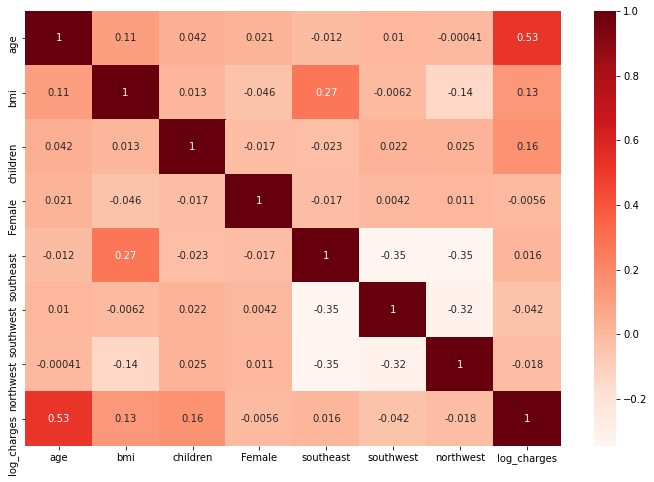

In [51]:
corr = df2.corr()
#corr_greater_than_80 = corr[corr>=.8]
#corr_greater_than_80

pyplot.figure(figsize=(12,8))
sns.heatmap(corr, annot = True, cmap="Reds")

<Figure size 1080x1080 with 0 Axes>

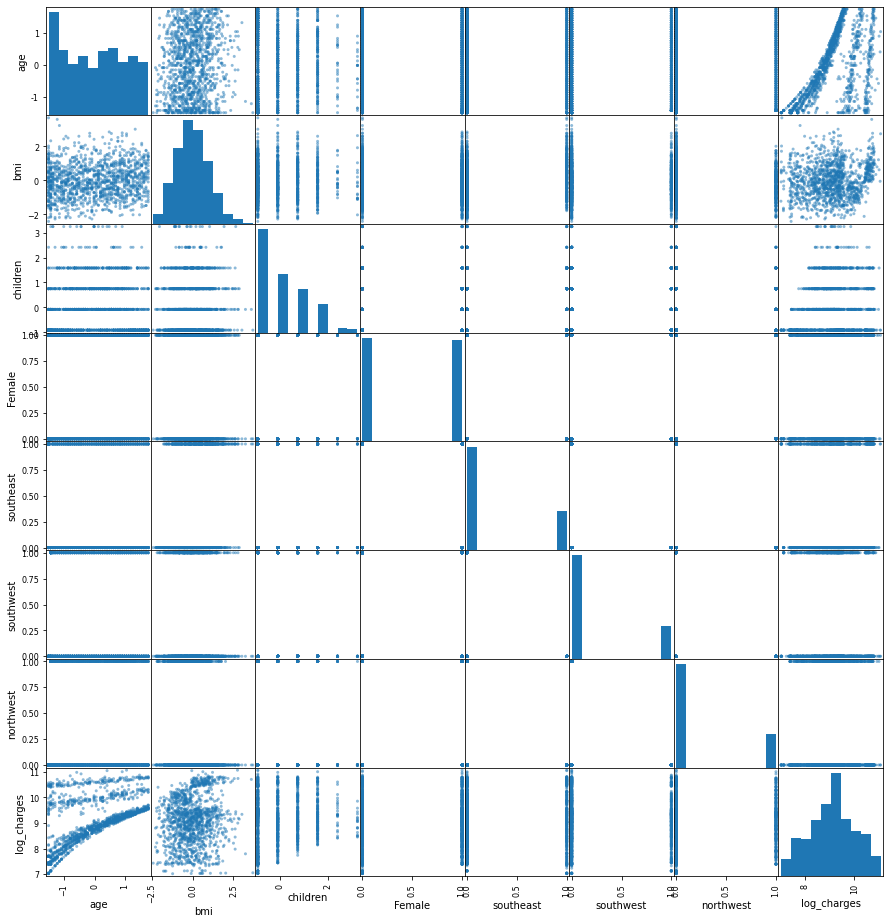

In [52]:
pyplot.figure(figsize=(15,15))
scatter_matrix(df2,figsize=(15,16))
pyplot.show()

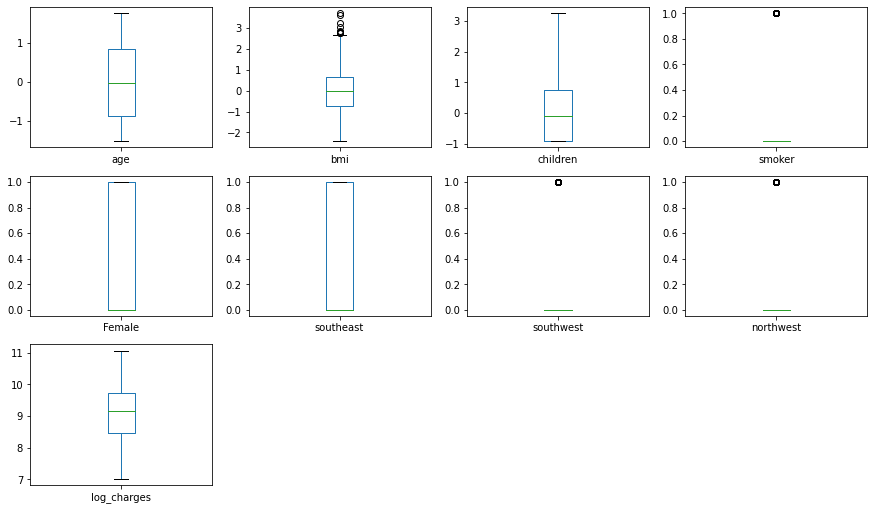

In [53]:
df2.plot(kind='box', subplots=True, layout=(5,4), sharex=False, sharey=False, figsize=(15,15))
pyplot.show()

### From the above graphs, we have the following obseravtions - 

#### 1. The charges are exponentially distributed, so we have to convert them to log of charges to get them close to a normal distribution.
#### 2. The log of charges is positively correlated to age and smoker.
#### 3. BMI doesn't have much effect on log of charges unless the person is a smoker. Then it is postively correlated.
#### 4. Region, gender and number of children doesn't have much affect on log of charges.
#### 5. The charges are high irrespective of age for smokers.
#### 6. There are some outliers in our data set, so we have used log transformation on charges and Standard Scaler on other values.

## 4. Data Preperation

In [57]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)

temp_Y = df2['log_charges']
temp_X = df2.drop(['log_charges'], axis = 1)
fit = bestfeatures.fit(temp_X,temp_Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(temp_X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(8,'Score')) 

       Specs        Score
3     smoker  1062.123923
0        age   515.977081
2   children    35.704670
1        bmi    23.936469
6  southwest     2.319613
7  northwest     0.424591
5  southeast     0.333210
4     Female     0.042376


### As was seen from our EDA, smoker and age are the most important features. The rest don't have much affect on our output.

## 5. Model Selection

### Train Test Split

In [60]:
Y = scaled_df2['log_charges']
X = scaled_df2.drop(['log_charges'], axis = 1)

validation_size = 0.2

seed = 3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [122]:
scores_df = pd.DataFrame(index= ['r2','evs','mae','mse','mape'])
scores_df

""
r2
evs
mae
mse
mape


### Linear Regression

In [61]:
kfold = KFold(n_splits=4)
#converted mean square error to positive. The lower the beter
cv_results = cross_val_score(LinearRegression(), X_train, Y_train, cv=kfold, scoring='r2')
cv_results.mean()

0.7741615928613202

R-squared score : 0.453336
Explained variance score : 0.453837
Mean Absolute Error : 4593.915452
Mean Squared error : 82451876.200364
Mean Absolute Percentage Error : 0.284288


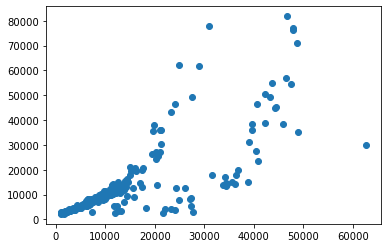

In [124]:
ols = LinearRegression().fit(X_train,Y_train)
predictions = ols.predict(X_test)

ols_r2 = r2_score(np.exp(Y_test), np.exp(predictions))
ols_evs = explained_variance_score(np.exp(Y_test), np.exp(predictions))
ols_mae = mean_absolute_error(np.exp(Y_test), np.exp(predictions))
ols_mse = mean_squared_error(np.exp(Y_test), np.exp(predictions))
ols_mape = mean_absolute_percentage_error(np.exp(Y_test), np.exp(predictions))

ols = [ols_r2,ols_evs,ols_mae,ols_mse,ols_mape]
scores_df['OLS'] = ols

print("R-squared score : %f"% ols_r2)
print("Explained variance score : %f"% ols_evs)
print("Mean Absolute Error : %f"% ols_mae)
print("Mean Squared error : %f"% ols_mse)
print("Mean Absolute Percentage Error : %f"% ols_mape)
pyplot.scatter(np.exp(Y_test), np.exp(predictions))

p value from Normal distribution test is 0.000000


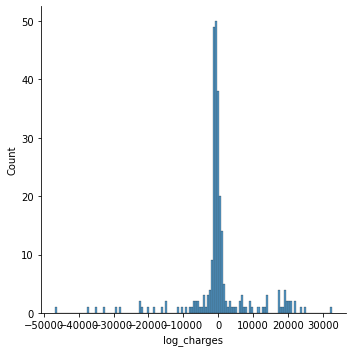

In [86]:
error = np.exp(Y_test) - np.exp(predictions)
k2, p = stats.normaltest(error)
print("p value from Normal distribution test is %f" %p)
sns.displot(error, kind = 'hist')

### Lasso Regression

In [93]:
kfold_results = []
for a in np.arange(0.001,0.003,0.0002):
    kfold = KFold(n_splits=4)
    cv_results = cross_val_score(Lasso(alpha = a), X_train, Y_train, cv=kfold, scoring='r2')
    kfold_results.append(cv_results.mean())
    print("When alpha = %f, %f" %(a, cv_results.mean()))

When alpha = 0.001000, 0.774110
When alpha = 0.001200, 0.774079
When alpha = 0.001400, 0.774043
When alpha = 0.001600, 0.773999
When alpha = 0.001800, 0.773949
When alpha = 0.002000, 0.773892
When alpha = 0.002200, 0.773829
When alpha = 0.002400, 0.773759
When alpha = 0.002600, 0.773682
When alpha = 0.002800, 0.773599


R-squared score : 0.461733
Explained variance score : 0.462432
Mean Absolute Error : 4558.152524
Mean Squared error : 81185472.155417
Mean Absolute Percentage Error : 0.283386


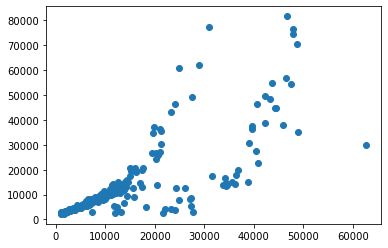

In [126]:
lasso = Lasso(alpha = 0.001).fit(X_train,Y_train)
predictions = lasso.predict(X_test)

lasso_r2 = r2_score(np.exp(Y_test), np.exp(predictions))
lasso_evs = explained_variance_score(np.exp(Y_test), np.exp(predictions))
lasso_mae = mean_absolute_error(np.exp(Y_test), np.exp(predictions))
lasso_mse = mean_squared_error(np.exp(Y_test), np.exp(predictions))
lasoo_mape = mean_absolute_percentage_error(np.exp(Y_test), np.exp(predictions))

lasso = [lasso_r2, lasso_evs, lasso_mae, lasso_mse, lasoo_mape]
scores_df['Lasso'] = lasso

print("R-squared score : %f"% lasso_r2)
print("Explained variance score : %f"% lasso_evs)
print("Mean Absolute Error : %f"% lasso_mae)
print("Mean Squared error : %f"% lasso_mse)
print("Mean Absolute Percentage Error : %f"% lasoo_mape)

pyplot.scatter(np.exp(Y_test), np.exp(predictions))

### Ridge Regression

In [96]:
kfold_results = []
for a in np.arange(0.001,10,1):
    kfold = KFold(n_splits=4)
    cv_results = cross_val_score(Ridge(alpha = a), X_train, Y_train, cv=kfold, scoring='r2')
    kfold_results.append(cv_results.mean())
    print("When alpha = %f, %f" %(a, cv_results.mean()))

When alpha = 0.001000, 0.774162
When alpha = 1.001000, 0.774186
When alpha = 2.001000, 0.774148
When alpha = 3.001000, 0.774052
When alpha = 4.001000, 0.773900
When alpha = 5.001000, 0.773695
When alpha = 6.001000, 0.773440
When alpha = 7.001000, 0.773137
When alpha = 8.001000, 0.772789
When alpha = 9.001000, 0.772397


R-squared score : 0.454179
Explained variance score : 0.454697
Mean Absolute Error : 4591.145278
Mean Squared error : 82324719.356089
Mean Absolute Percentage Error : 0.284270


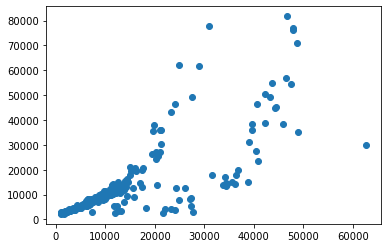

In [128]:
ridge = Ridge(alpha = 0.1).fit(X_train,Y_train)
predictions = ridge.predict(X_test)

ridge_r2 = r2_score(np.exp(Y_test), np.exp(predictions))
ridge_evs = explained_variance_score(np.exp(Y_test), np.exp(predictions))
ridge_mae = mean_absolute_error(np.exp(Y_test), np.exp(predictions))
ridge_mse = mean_squared_error(np.exp(Y_test), np.exp(predictions))
ridge_mape = mean_absolute_percentage_error(np.exp(Y_test), np.exp(predictions))

ridge = [ridge_r2, ridge_evs, ridge_mae, ridge_mse, ridge_mape]
scores_df['Ridge'] = ridge

print("R-squared score : %f"% ridge_r2)
print("Explained variance score : %f"% ridge_evs)
print("Mean Absolute Error : %f"% ridge_mae)
print("Mean Squared error : %f"% ridge_mse)
print("Mean Absolute Percentage Error : %f"% ridge_mape)

pyplot.scatter(np.exp(Y_test),np.exp(predictions))

### Elastic Net

In [102]:
param_grid = {'alpha': [0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5], 'l1_ratio': [0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5]}

kfold = KFold(n_splits=4)
grid = GridSearchCV(ElasticNet(), param_grid=param_grid, scoring='r2', cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.774186 using {'alpha': 0.001, 'l1_ratio': 0.0001}
0.774166 (0.019492) with: {'alpha': 0.0001, 'l1_ratio': 0.0001}
0.774166 (0.019492) with: {'alpha': 0.0001, 'l1_ratio': 0.001}
0.774166 (0.019492) with: {'alpha': 0.0001, 'l1_ratio': 0.01}
0.774166 (0.019488) with: {'alpha': 0.0001, 'l1_ratio': 0.1}
0.774166 (0.019485) with: {'alpha': 0.0001, 'l1_ratio': 0.2}
0.774165 (0.019481) with: {'alpha': 0.0001, 'l1_ratio': 0.3}
0.774165 (0.019478) with: {'alpha': 0.0001, 'l1_ratio': 0.4}
0.774165 (0.019474) with: {'alpha': 0.0001, 'l1_ratio': 0.5}
0.774186 (0.019346) with: {'alpha': 0.001, 'l1_ratio': 0.0001}
0.774186 (0.019345) with: {'alpha': 0.001, 'l1_ratio': 0.001}
0.774186 (0.019342) with: {'alpha': 0.001, 'l1_ratio': 0.01}
0.774184 (0.019311) with: {'alpha': 0.001, 'l1_ratio': 0.1}
0.774181 (0.019275) with: {'alpha': 0.001, 'l1_ratio': 0.2}
0.774176 (0.019240) with: {'alpha': 0.001, 'l1_ratio': 0.3}
0.774170 (0.019205) with: {'alpha': 0.001, 'l1_ratio': 0.4}
0.774164 (0.019170) wi

R-squared score : 0.462129
Explained variance score : 0.462827
Mean Absolute Error : 4564.595310
Mean Squared error : 81125739.498183
Mean Absolute Percentage Error : 0.284109


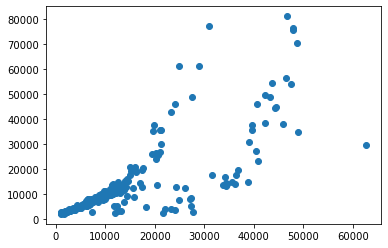

In [129]:
elastic = ElasticNet(alpha = 0.001, l1_ratio = 0.0001).fit(X_train,Y_train)
predictions = elastic.predict(X_test)

elastic_r2 = r2_score(np.exp(Y_test), np.exp(predictions))
elastic_evs = explained_variance_score(np.exp(Y_test), np.exp(predictions))
elastic_mae = mean_absolute_error(np.exp(Y_test), np.exp(predictions))
elastic_mse = mean_squared_error(np.exp(Y_test), np.exp(predictions))
elastic_mape = mean_absolute_percentage_error(np.exp(Y_test), np.exp(predictions))

elastic = [elastic_r2, elastic_evs, elastic_mae, elastic_mse, elastic_mape]
scores_df['ElasticNet'] = elastic

print("R-squared score : %f"% elastic_r2)
print("Explained variance score : %f"% elastic_evs)
print("Mean Absolute Error : %f"% elastic_mae)
print("Mean Squared error : %f"% elastic_mse)
print("Mean Absolute Percentage Error : %f"% elastic_mape)

pyplot.scatter(np.exp(Y_test),np.exp(predictions))

### KNN Regression

In [104]:
param_grid = {'n_neighbors':np.arange(1,20)}

kfold = KFold(n_splits=4)
grid = GridSearchCV(KNeighborsRegressor(), param_grid=param_grid, scoring='r2', cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.688793 using {'n_neighbors': 4}
0.584795 (0.011796) with: {'n_neighbors': 1}
0.645635 (0.017592) with: {'n_neighbors': 2}
0.686263 (0.010976) with: {'n_neighbors': 3}
0.688793 (0.013496) with: {'n_neighbors': 4}
0.682421 (0.009787) with: {'n_neighbors': 5}
0.685680 (0.010758) with: {'n_neighbors': 6}
0.679552 (0.016128) with: {'n_neighbors': 7}
0.674003 (0.017907) with: {'n_neighbors': 8}
0.664718 (0.018471) with: {'n_neighbors': 9}
0.660819 (0.024564) with: {'n_neighbors': 10}
0.652177 (0.025651) with: {'n_neighbors': 11}
0.646095 (0.022480) with: {'n_neighbors': 12}
0.643918 (0.024983) with: {'n_neighbors': 13}
0.641304 (0.029676) with: {'n_neighbors': 14}
0.636438 (0.028625) with: {'n_neighbors': 15}
0.641162 (0.026357) with: {'n_neighbors': 16}
0.635769 (0.026212) with: {'n_neighbors': 17}
0.628436 (0.026126) with: {'n_neighbors': 18}
0.626201 (0.023573) with: {'n_neighbors': 19}


R-squared score : 0.507141
Explained variance score : 0.575717
Mean Absolute Error : 4403.946641
Mean Squared error : 74336640.148710
Mean Absolute Percentage Error : 0.261132


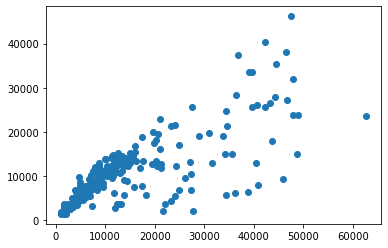

In [130]:
knn = KNeighborsRegressor(n_neighbors = 7).fit(X_train,Y_train)
predictions = knn.predict(X_test)

knn_r2 = r2_score(np.exp(Y_test), np.exp(predictions))
knn_evs = explained_variance_score(np.exp(Y_test), np.exp(predictions))
knn_mae = mean_absolute_error(np.exp(Y_test), np.exp(predictions))
knn_mse = mean_squared_error(np.exp(Y_test), np.exp(predictions))
knn_mape = mean_absolute_percentage_error(np.exp(Y_test), np.exp(predictions))

knn = [knn_r2, knn_evs, knn_mae, knn_mse, knn_mape]
scores_df['KNN'] = knn

print("R-squared score : %f"% knn_r2)
print("Explained variance score : %f"% knn_evs)
print("Mean Absolute Error : %f"% knn_mae)
print("Mean Squared error : %f"% knn_mse)
print("Mean Absolute Percentage Error : %f"% knn_mape)

pyplot.scatter(np.exp(Y_test),np.exp(predictions))

### Decision Tree

In [106]:
kfold_results = []
for a in range(1,10):
    kfold = KFold(n_splits=4)
    cv_results = cross_val_score(DecisionTreeRegressor(max_depth = a), X_train, Y_train, cv=kfold, scoring='r2')
    kfold_results.append(cv_results.mean())
    print("When max_depth = %f, %f" %(a, cv_results.mean()))

When max_depth = 1.000000, 0.438605
When max_depth = 2.000000, 0.733489
When max_depth = 3.000000, 0.802142
When max_depth = 4.000000, 0.824363
When max_depth = 5.000000, 0.822387
When max_depth = 6.000000, 0.808586
When max_depth = 7.000000, 0.774083
When max_depth = 8.000000, 0.734579
When max_depth = 9.000000, 0.706286


R-squared score : 0.861080
Explained variance score : 0.864412
Mean Absolute Error : 2136.006035
Mean Squared error : 20952968.970752
Mean Absolute Percentage Error : 0.183702


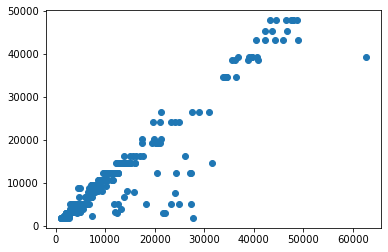

In [134]:
dtr = DecisionTreeRegressor(max_depth=5).fit(X_train,Y_train)
predictions = dtr.predict(X_test)

dtr_r2 = r2_score(np.exp(Y_test), np.exp(predictions))
dtr_evs = explained_variance_score(np.exp(Y_test), np.exp(predictions))
dtr_mae = mean_absolute_error(np.exp(Y_test), np.exp(predictions))
dtr_mse = mean_squared_error(np.exp(Y_test), np.exp(predictions))
dtr_mape = mean_absolute_percentage_error(np.exp(Y_test), np.exp(predictions))

dtr = [dtr_r2, dtr_evs, dtr_mae, dtr_mse, dtr_mape]
scores_df['DecisionTree'] = dtr

print("R-squared score : %f"% dtr_r2)
print("Explained variance score : %f"% dtr_evs)
print("Mean Absolute Error : %f"% dtr_mae)
print("Mean Squared error : %f"% dtr_mse)
print("Mean Absolute Percentage Error : %f"% dtr_mape)

pyplot.scatter(np.exp(Y_test),np.exp(predictions))

### SVR

In [110]:
param_grid = {'C': np.arange(1, 3, 0.2), 'epsilon': np.arange(0.1, 0.5, 0.1)}

kfold = KFold(n_splits=4)
grid = GridSearchCV(SVR(), param_grid=param_grid, scoring='r2', cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.828859 using {'C': 2.8, 'epsilon': 0.1}
0.825076 (0.028515) with: {'C': 1.0, 'epsilon': 0.1}
0.821584 (0.026081) with: {'C': 1.0, 'epsilon': 0.2}
0.797993 (0.024350) with: {'C': 1.0, 'epsilon': 0.30000000000000004}
0.758912 (0.022493) with: {'C': 1.0, 'epsilon': 0.4}
0.826213 (0.029013) with: {'C': 1.2, 'epsilon': 0.1}
0.822778 (0.025942) with: {'C': 1.2, 'epsilon': 0.2}
0.799354 (0.023641) with: {'C': 1.2, 'epsilon': 0.30000000000000004}
0.759499 (0.022981) with: {'C': 1.2, 'epsilon': 0.4}
0.826867 (0.028985) with: {'C': 1.4, 'epsilon': 0.1}
0.823369 (0.025682) with: {'C': 1.4, 'epsilon': 0.2}
0.799798 (0.023633) with: {'C': 1.4, 'epsilon': 0.30000000000000004}
0.759828 (0.023325) with: {'C': 1.4, 'epsilon': 0.4}
0.827322 (0.028613) with: {'C': 1.5999999999999999, 'epsilon': 0.1}
0.823902 (0.025360) with: {'C': 1.5999999999999999, 'epsilon': 0.2}
0.800064 (0.023358) with: {'C': 1.5999999999999999, 'epsilon': 0.30000000000000004}
0.760173 (0.023341) with: {'C': 1.59999999999999

R-squared score : 0.825427
Explained variance score : 0.829868
Mean Absolute Error : 2369.363593
Mean Squared error : 26330347.406570
Mean Absolute Percentage Error : 0.140078


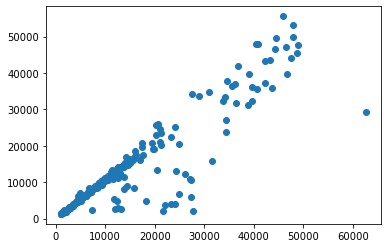

In [135]:
svr = SVR(C = 2.8, epsilon = 0.1).fit(X_train,Y_train)
predictions = svr.predict(X_test)

svr_r2 = r2_score(np.exp(Y_test), np.exp(predictions))
svr_evs = explained_variance_score(np.exp(Y_test), np.exp(predictions))
svr_mae = mean_absolute_error(np.exp(Y_test), np.exp(predictions))
svr_mse = mean_squared_error(np.exp(Y_test), np.exp(predictions))
svr_mape = mean_absolute_percentage_error(np.exp(Y_test), np.exp(predictions))

svr = [svr_r2, svr_evs, svr_mae, svr_mse, svr_mape]
scores_df['SVR'] = svr

print("R-squared score : %f"% svr_r2)
print("Explained variance score : %f"% svr_evs)
print("Mean Absolute Error : %f"% svr_mae)
print("Mean Squared error : %f"% svr_mse)
print("Mean Absolute Percentage Error : %f"% svr_mape)

pyplot.scatter(np.exp(Y_test),np.exp(predictions))

### Polynomial Regression

In [150]:
kfold_results = []
for a in range(1,6):
    poly_reg = PolynomialFeatures(degree=a)
    X_train_poly = poly_reg.fit_transform(X_train)
    kfold = KFold(n_splits=4)
    cv_results = cross_val_score(LinearRegression(), X_train_poly, Y_train, cv=kfold, scoring='r2')
    kfold_results.append(cv_results.mean())
    print("When alpha = %f, %f" %(a, cv_results.mean()))

When alpha = 1.000000, 0.774162
When alpha = 2.000000, 0.839864
When alpha = 3.000000, 0.831212
When alpha = 4.000000, 0.684322
When alpha = 5.000000, -1093.467862


R-squared score : 0.808721
Explained variance score : 0.812520
Mean Absolute Error : 2686.698831
Mean Squared error : 28850118.016352
Mean Absolute Percentage Error : 0.181231


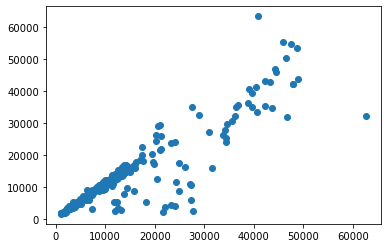

In [154]:
poly_reg = PolynomialFeatures(degree=2)
X_train_poly = poly_reg.fit_transform(X_train)

prm = LinearRegression().fit(X_train_poly, Y_train)
predictions = prm.predict(poly_reg.fit_transform(X_test))

prm_r2 = r2_score(np.exp(Y_test), np.exp(predictions))
prm_evs = explained_variance_score(np.exp(Y_test), np.exp(predictions))
prm_mae = mean_absolute_error(np.exp(Y_test), np.exp(predictions))
prm_mse = mean_squared_error(np.exp(Y_test), np.exp(predictions))
prm_mape = mean_absolute_percentage_error(np.exp(Y_test), np.exp(predictions))

prm = [prm_r2, prm_evs, prm_mae, prm_mse, prm_mape]
scores_df['Polynomial Regression'] = prm

print("R-squared score : %f"% prm_r2)
print("Explained variance score : %f"% prm_evs)
print("Mean Absolute Error : %f"% prm_mae)
print("Mean Squared error : %f"% prm_mse)
print("Mean Absolute Percentage Error : %f"% prm_mape)

pyplot.scatter(np.exp(Y_test),np.exp(predictions))

## 6. Final Results

In [155]:
pd.options.display.float_format = "{:,.4f}".format
scores_df

,OLS,Lasso,Ridge,ElasticNet,KNN,DecisionTree,SVR,Polynomial Regression
r2,0.4533,0.4617,0.4542,0.4621,0.5071,0.8611,0.8254,0.8087
evs,0.4538,0.4624,0.4547,0.4628,0.5757,0.8644,0.8299,0.8125
mae,"4,593.9155","4,558.1525","4,591.1453","4,564.5953","4,403.9466","2,136.0060","2,369.3636","2,686.6988"
mse,"82,451,876.2004","81,185,472.1554","82,324,719.3561","81,125,739.4982","74,336,640.1487","20,952,968.9708","26,330,347.4066","28,850,118.0164"
mape,0.2843,0.2834,0.2843,0.2841,0.2611,0.1837,0.1401,0.1812


### From the above regression models, we can see that the linear models have not performed particularly well in predicting the charges. The non-linear models have been better. With Decision Trees being the clear winner.